<a href="https://colab.research.google.com/github/wqiu96/summer_project/blob/master/src/nn3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/wqiu96/summer_project.git

Cloning into 'summer_project'...
remote: Enumerating objects: 130, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 767 (delta 74), reused 0 (delta 0), pack-reused 637
Receiving objects: 100% (767/767), 2.73 MiB | 6.30 MiB/s, done.
Resolving deltas: 100% (401/401), done.


In [2]:
cd summer_project/src/

/content/summer_project/src


In [3]:
pip install ipdb

  Created wheel for ipdb: filename=ipdb-0.12.3-cp36-none-any.whl size=9223 sha256=d2aed99956122b832d8c57e74264728bab6b329235d5e07988356ad289aba11a
  Stored in directory: /root/.cache/pip/wheels/57/43/c5/614153606de8f5e358e266723f53254e70752f4ffc8c85ec63
Successfully built ipdb


In [0]:
import numpy as np
import time
import ipdb
import torch
import torch.nn as nn
import itertools
import matplotlib.pyplot as plt

import itertools
def deep_iter(*shape):
    iters = (range(i) for i in shape)
    return itertools.product(*iters)
        
        

class Pde:
    def __init__(
            self,
            dim=1,
            lam=0.0,
            drift = lambda s,a: np.array([0.]),
            run_cost = lambda s,a: -1.0,
            term_cost = lambda s: sum(map(lambda a: 0.5*a**2 - 0.5*a, s)),
            limit_s = 1.0, #l-infinity limit for state
            limit_a = 0, #l-infinity limit for action
            verbose=True
    ):
        self.dim = dim
        self.lam = lam
        self.drift = drift
        self.run_cost = run_cost
        self.term_cost = term_cost            
        self.limit_s = limit_s
        self.limit_a = limit_a

        if verbose:
            print(str(dim) + '-dim HJB')
    
    #domain is a unit hyper cube        
    def is_interior(self, s):
        return all(0<s<1)
    
    #cfd2mdp
    def mdp(self, n_mesh_s = 8, n_mesh_a = 16, method='cfd'):
        out = {}
        
        ####domain of mdp
        h_s = self.limit_s/n_mesh_s #mesh size in state
        h_a = self.limit_a/n_mesh_a #mesh size in action
        self.v_shape = tuple([n_mesh_s + 1]*self.dim)
        self.a_shape = tuple([n_mesh_a + 1]*self.dim)
        
        def is_interior(*ix_s):
            return all([0<x<n_mesh_s for x in ix_s])
        
        out.update({
                'v_shape': self.v_shape,
                'a_shape': self.a_shape,
                'is_interior': is_interior,
                'n_mesh_s':n_mesh_s
                })
        ####domain
 
       # convert index(tuple) to state
        def i2s(*ix): 
            return np.array([x * h_s for x in ix])       
        out['i2s'] = i2s
        #convert index to action
        def i2a(*ix):
            return np.array([x * h_a for x in ix])
        #out['i2a'] = i2a


       
        ########running and terminal costs and discount rate
        def run_cost(ix_s,ix_a):
            return self.run_cost(i2s(*ix_s), i2a(*ix_a))*h_s**2/self.dim
        
        def term_cost(ix_s):
            return self.term_cost(i2s(*ix_s))
        
        rate = self.dim/(self.dim+self.lam*(h_s**2))
        out.update({
                'run_cost': run_cost,
                'term_cost': term_cost,
                'rate': rate
                })
        #########
        
        #####transition
        #return:
        #   a list of nbd indices
        #   a list of prob
        def step(ix_s, ix_a):
            ix_next_s_up = (np.array(ix_s)+np.eye(self.dim)).astype(int).tolist()
            ix_next_s_dn = (np.array(ix_s)-np.eye(self.dim)).astype(int).tolist()
            ix_next_s = [tuple(ix) for ix in ix_next_s_up+ix_next_s_dn]
            
            pr=[]
            if method == 'cfd':
                b = self.drift(i2s(*ix_s), i2a(*ix_a))
                pr_up = ((1+2.*h_s*b)/self.dim/2.0).tolist()
                pr_dn = ((1-2.*h_s*b)/self.dim/2.0).tolist()
                pr = pr_up+pr_dn
            
            return ix_next_s, pr, run_cost(ix_s,ix_a)
        out.update({'step': step,
                    'dim': self.dim})

        
        def bellman(ix, ia, v):
            s = i2s(*ix)
            disc = rate
            ix_next, pr_next,run_h = step(ix,ia)
            lhs = v(torch.FloatTensor(s)); rhs = 0.
            #ipdb.set_trace()
            if is_interior(*ix):            
                rhs += run_h 
                for ix1, pr1 in zip(ix_next, pr_next):
                    rhs += pr1*v(torch.FloatTensor(i2s(*ix1)))
                rhs *= disc
                res = (rhs - lhs)
            else:
                rhs = self.term_cost(ix)
                res = (rhs - lhs)
            return res
        out.update({
                'bellman': bellman
                })
    
        return out

def solver(mdp, n_epoch = 500):
    ######### nn for value
    # Linear regression model
    value = nn.Sequential(
        nn.Linear(mdp['dim'], 2*mdp['dim']+10),
        #nn.functional.gelu(),
        nn.ReLU(),
        nn.Linear(2*mdp['dim']+10, 2*mdp['dim']+10),
        nn.ReLU(),
        nn.Linear(2*mdp['dim']+10, 1)
    )   
    print(value)
    #loss
    def tot_loss():
        out = 0.
      
        for ix in deep_iter(*mdp['v_shape']):
          ia = tuple([0]*mdp['dim'])
          if m['is_interior'](*ix):
            #out += abs(mdp['term_cost'](ix) - value(torch.FloatTensor(mdp['i2s'](*ix))))
            out += mdp['bellman'](ix,ia,value)**2

        return 3000*out #/mdp.v_size_
    
    print_n = 10
    epoch_per_print= int(n_epoch/print_n)
    
    start_time = time.time()
    for epoch in range(n_epoch):
        #ipdb.set_trace()
        loss = tot_loss() #forward pass
        #backward propogation
        # optimizer
        lr = max(1/((epoch+100.)), .0001)
        optimizer = torch.optim.SGD(value.parameters(), lr, momentum = .8) 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (epoch) % epoch_per_print == 0:
          print('Epoch [{}/{}], Loss: {:.4f}'.format(
                  epoch+1, n_epoch, loss.item()))
        if loss.item()<0.0002:
            break
    end_time = time.time()
    print('>>>time elapsed is: ' + str(end_time - start_time))
    return value

1-dim HJB
Sequential(
  (0): Linear(in_features=1, out_features=12, bias=True)
  (1): ReLU()
  (2): Linear(in_features=12, out_features=12, bias=True)
  (3): ReLU()
  (4): Linear(in_features=12, out_features=1, bias=True)
)
Epoch [1/1000], Loss: 0.6308
Epoch [101/1000], Loss: 0.5228
Epoch [201/1000], Loss: 0.4611
Epoch [301/1000], Loss: 0.4665
Epoch [401/1000], Loss: 0.4447
Epoch [501/1000], Loss: 0.4331
Epoch [601/1000], Loss: 0.4266
Epoch [701/1000], Loss: 0.4227
Epoch [801/1000], Loss: 0.4202
Epoch [901/1000], Loss: 0.4185
>>>time elapsed is: 15.329895257949829


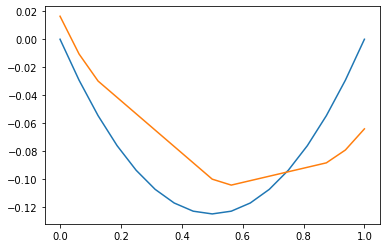

In [5]:
torch.manual_seed(0)
p = Pde(dim=1) 
m = p.mdp(n_mesh_s= 16)
value = solver(m, n_epoch=1000)
######check solution
err =0
for ix1 in deep_iter(*m['v_shape']):
    s1 = m['i2s'](*ix1)
    v1 = value(torch.FloatTensor(s1)).item()
    exact_v1 =p.term_cost(s1) 
    err1 = v1-exact_v1
    err += err1**2

#err = err/m.v_size_
#print('>>>L2-error-norm: '+str(err))


if p.dim ==1:
    cod_x = []; cod_y=[]; cod_y_pred = []
    for ix1 in deep_iter(*m['v_shape']):
        s1 = m['i2s'](*ix1); cod_x += [s1,]
        v1 = value(torch.FloatTensor(s1)).item(); cod_y_pred += [v1,]
        exact_v1 =p.term_cost(s1); cod_y += [exact_v1,]

    plt.plot(cod_x, cod_y, cod_x, cod_y_pred)


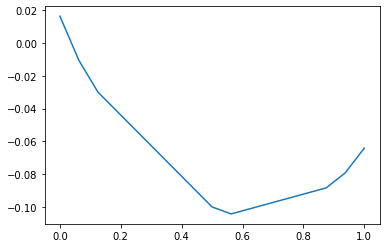

In [6]:

if p.dim ==1:
    cod_x = []; cod_y=[]; cod_y_pred = []
    for ix1 in deep_iter(*m['v_shape']):
        s1 = m['i2s'](*ix1); cod_x += [s1,]
        v1 = value(torch.FloatTensor(s1)).item(); cod_y_pred += [v1,]
        exact_v1 =p.term_cost(s1); cod_y += [exact_v1,]

    plt.plot(cod_x, cod_y_pred)

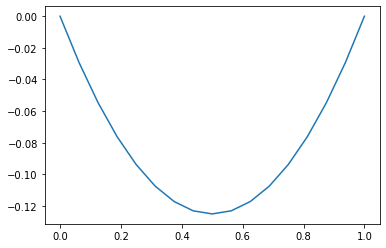

In [7]:
plt.plot(cod_x, cod_y)